In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.autograd import Variable
from IPython.display import Image
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

# arguments

In [2]:
batch_size = 128
epochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Prepare Dataset

In [3]:
mnist_transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
download_root = './MNIST_DATASET'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

In [5]:
train_loader = DataLoader(dataset=train_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         shuffle=True)

# a, _ = test_dataset.__getitem__(0)
# torch.tensor(np.array(a))
# 28*28 shape data

# Define Model

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.MLP= nn.Sequential(nn.Linear(28*28, 400), nn.PReLU(),
                                nn.Linear(400, 40))
        
        self.fc_mu = nn.Linear(40,20)
        self.fc_var = nn.Linear(40,20)
        
    def forward(self, x):
        bs = x.shape[0]
        out = self.MLP(x.reshape(bs, -1))
#         mu, log_var = torch.chunk(out, 2, dim=1)
        mu = self.fc_mu(out)
        log_var = self.fc_var(out)
        return mu, log_var
        

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.MLP = nn.Sequential(nn.Linear(20, 400), nn.PReLU(),
                                nn.Linear(400, 28*28), nn.Sigmoid())
        
    def forward(self, x):
        bs = x.shape[0]
        out = self.MLP(x).reshape(bs, 1, 28, 28)
        return out
        

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparam(mean, log_var)
        out = self.decoder(z)
        kld_loss = -0.5*torch.sum(1+log_var - mean**2 - log_var.exp())
        
        return out, kld_loss
        
    def reparam(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        z = Variable(torch.randn(mean.shape, device=device))
        return mean+std*z

# model prepare

In [9]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
recon_criterion = nn.BCELoss(reduction = 'sum')

In [10]:
for epoch in range(0, epochs):
    for iteration, (data, _) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        recon, kld_loss = model(data.to(device))
        recon_loss = recon_criterion(recon, data.to(device))
        loss = kld_loss + recon_loss
        
        loss.backward()
        optimizer.step()
        
    loss = 0
    for iteration, (data, _) in enumerate(test_loader):
        model.eval()
        with torch.no_grad():
            recon, kld_loss = model(data.to(device))

            recon_loss = recon_criterion(recon, data.to(device))
            loss += (kld_loss + recon_loss)

    print(epoch, loss/test_dataset.__len__())

0 tensor(131.9610, device='cuda:0')
1 tensor(117.9757, device='cuda:0')
2 tensor(112.8055, device='cuda:0')
3 tensor(109.9588, device='cuda:0')
4 tensor(108.5038, device='cuda:0')
5 tensor(107.4166, device='cuda:0')
6 tensor(106.8841, device='cuda:0')
7 tensor(105.9999, device='cuda:0')
8 tensor(105.3513, device='cuda:0')
9 tensor(105.0635, device='cuda:0')


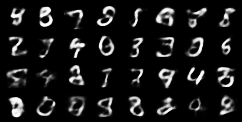

In [11]:
z = Normal(0,1).sample((32,20)).to(device)
out = model.decoder(z)
save_image(out.view(out.size(0), 1, 28, 28).data.cpu(), 'sample_image.png')
Image('sample_image.png')